In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [5]:
import pandas as pd
# This is fine since it's an Excel file
PCOS_woinf = pd.read_excel("/content/PCOS_data_without_infertility.xlsx", sheet_name="Full_new")
# This should be read using read_csv
PCOS_inf = pd.read_csv("/content/PCOS_infertility.csv")

In [6]:
print(PCOS_inf.head())

   Sl. No  Patient File No.  PCOS (Y/N)    I   beta-HCG(mIU/mL)  \
0       1             10001           0                    1.99   
1       2             10002           0                   60.80   
2       3             10003           1                  494.08   
3       4             10004           0                    1.99   
4       5             10005           0                  801.45   

   II    beta-HCG(mIU/mL) AMH(ng/mL)  
0                    1.99       2.07  
1                    1.99       1.53  
2                  494.08       6.63  
3                    1.99       1.22  
4                  801.45       2.26  


In [7]:
print(PCOS_woinf.head())

   Sl. No  Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)   \
0       1                 1           0          28         44.6        152.0   
1       2                 2           0          36         65.0        161.5   
2       3                 3           1          33         68.8        165.0   
3       4                 4           0          37         65.0        148.0   
4       5                 5           0          25         52.0        161.0   

         BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  ...  \
0  19.300000           15                78                22  ...   
1  24.921163           15                74                20  ...   
2  25.270891           11                72                18  ...   
3  29.674945           13                72                20  ...   
4  20.060954           11                72                18  ...   

   Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0              1.0            

## DATA PREPROCESSING

Merging the two files as per patient file no. and dropping the repeated features

In [8]:
#Merging the two files as per patient file no.
#The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes=['','_y'],how='left')
#Dropping the repeated features after merging
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)
#Taking a look at the dataset
data.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

## Encoding categorical variables (dtype objects)

In [10]:
#Dealing with categorical values.
#In this database the type objects are numeric values saved as strings.
#So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

#Dealing with missing values.
#Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

#Clearing up the extra space in the column names (optional)

data.columns = [col.strip() for col in data.columns]

<ipython-input-10-2209a674dd8f>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
<ipython-input-10-2209a674dd8f>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[

### EXPLORATORY DATA ANALYSIS

In [11]:
data.describe()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,271.000000,271.000000,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,156.317519,156.317519,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,1.000000,1.000000,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,136.000000,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,271.000000,271.000000,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,406.000000,406.000000,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,541.000000,541.000000,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


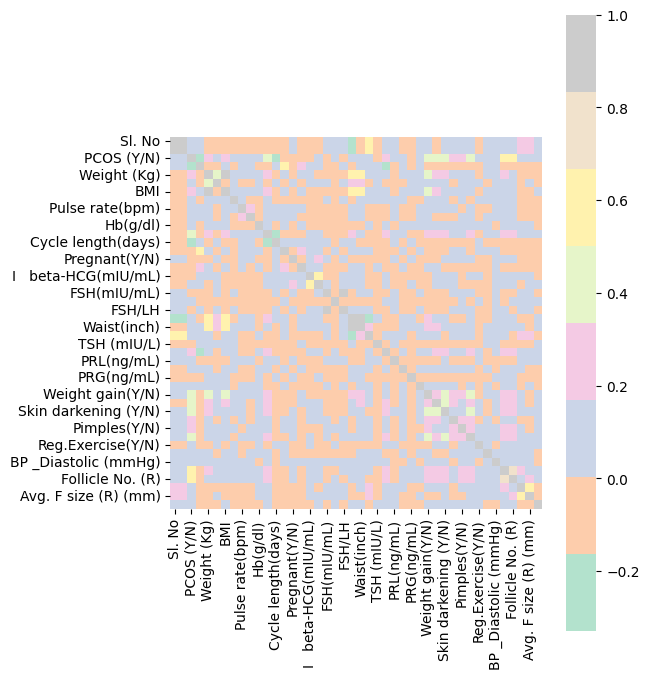

In [12]:
#Examaning a correlation matrix of all the features
corrmat = data.corr()
plt.subplots(figsize=(6,8))
sns.heatmap(corrmat,cmap="Pastel2", square=True);

In [13]:
#How all the features correlate with the PCOS
corrmat["PCOS (Y/N)"].sort_values(ascending=False)

,PCOS (Y/N)
PCOS (Y/N),1.000000
Follicle No. (R),0.648327
Follicle No. (L),0.603346
Skin darkening (Y/N),0.475733
hair growth(Y/N),0.464667
Weight gain(Y/N),0.441047
Cycle(R/I),0.401644
Fast food (Y/N),0.376183
Pimples(Y/N),0.286077
AMH(ng/mL),0.264141


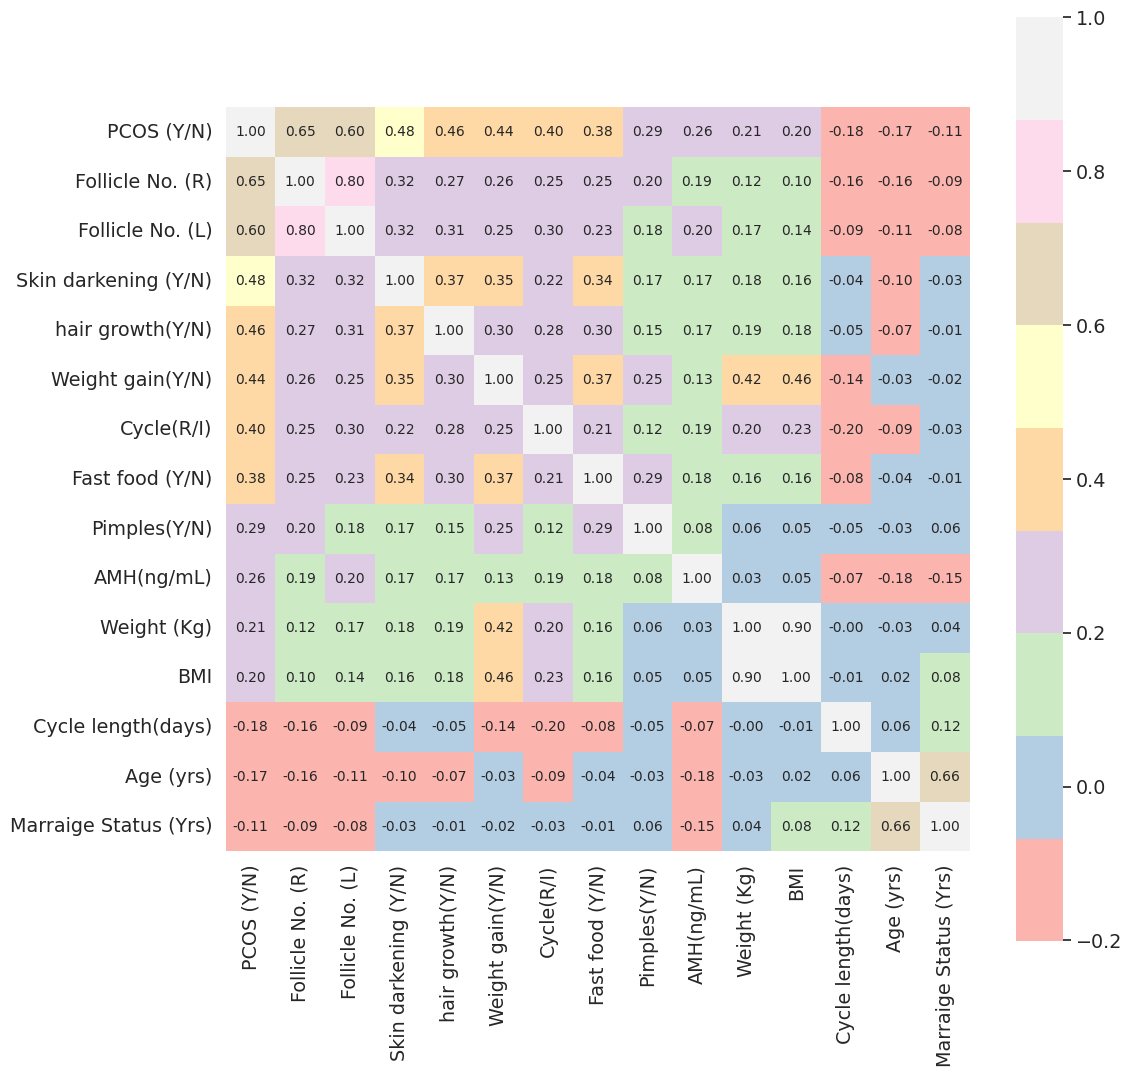

In [14]:
#Having a look at features bearing significant correlation
import numpy as np
plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols_n = corrmat.nsmallest(l, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols = cols_p.append(cols_n)

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Pastel1", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

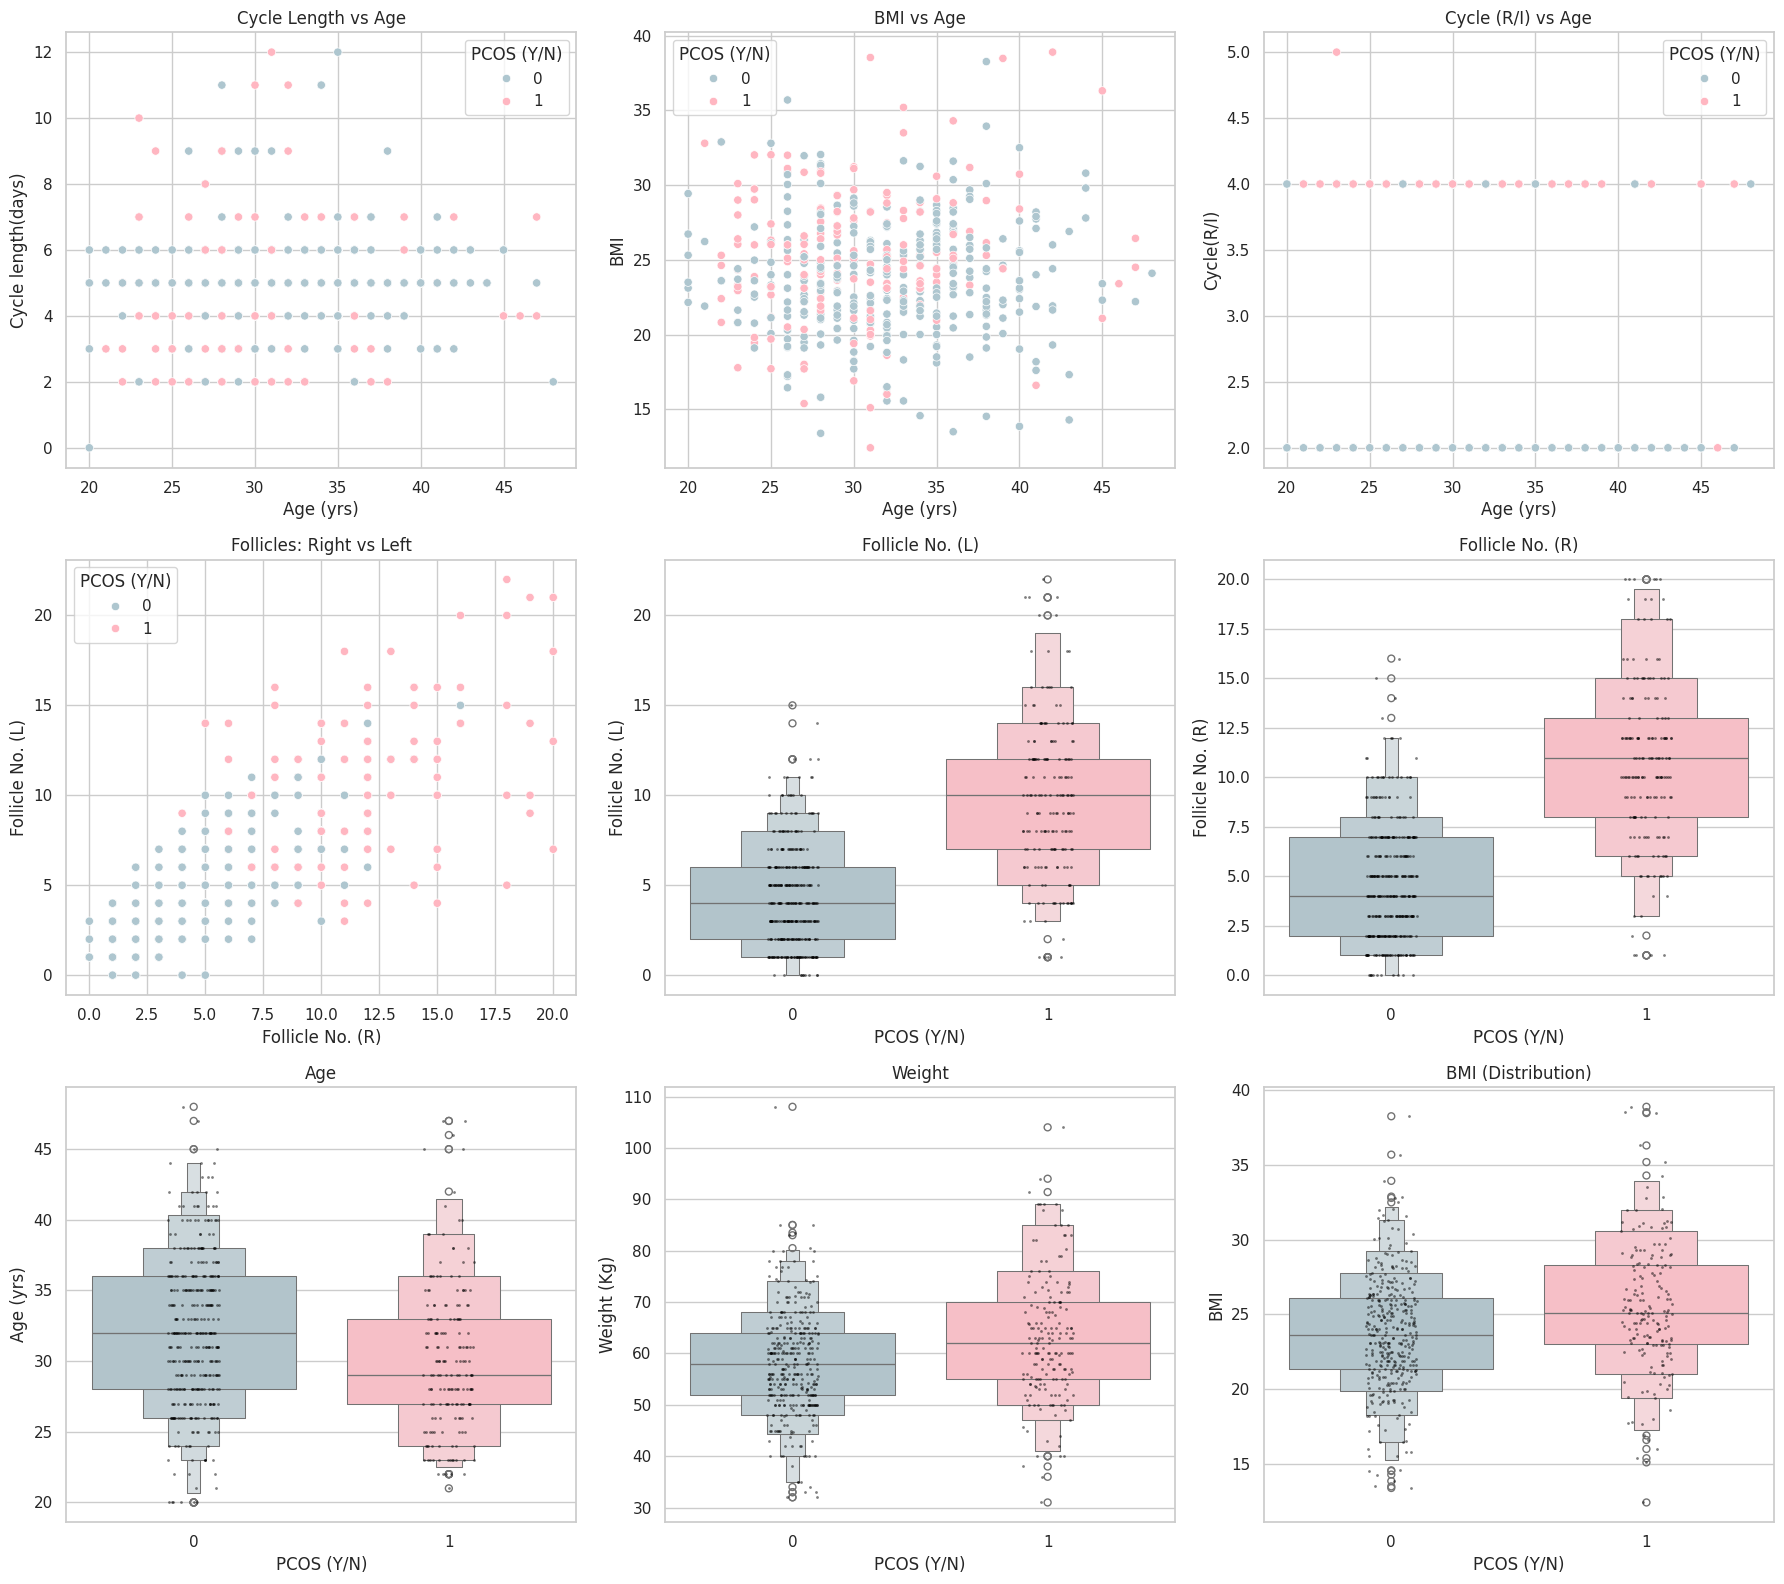

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set seaborn style
sns.set(style="whitegrid", palette="pastel")

# Custom pastel colors for PCOS vs Normal
pastel_colors = ["#AEC6CF", "#FFB6C1"]

# Create subplot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes = axes.flatten()

# Plot 1: Cycle length vs Age
sns.scatterplot(data=data, x="Age (yrs)", y="Cycle length(days)", hue="PCOS (Y/N)", palette=pastel_colors, ax=axes[0])
axes[0].set_title("Cycle Length vs Age")

# Plot 2: BMI vs Age
sns.scatterplot(data=data, x="Age (yrs)", y="BMI", hue="PCOS (Y/N)", palette=pastel_colors, ax=axes[1])
axes[1].set_title("BMI vs Age")

# Plot 3: Cycle (R/I) vs Age
sns.scatterplot(data=data, x="Age (yrs)", y="Cycle(R/I)", hue="PCOS (Y/N)", palette=pastel_colors, ax=axes[2])
axes[2].set_title("Cycle (R/I) vs Age")

# Plot 4: Follicle No. (R) vs Follicle No. (L)
sns.scatterplot(data=data, x="Follicle No. (R)", y="Follicle No. (L)", hue="PCOS (Y/N)", palette=pastel_colors, ax=axes[3])
axes[3].set_title("Follicles: Right vs Left")

# Plot 5: Follicle No. (L)
sns.boxenplot(x="PCOS (Y/N)", y="Follicle No. (L)", hue="PCOS (Y/N)", data=data, palette=pastel_colors, legend=False, ax=axes[4])
sns.stripplot(x="PCOS (Y/N)", y="Follicle No. (L)", data=data, color="black", alpha=0.5, size=2, ax=axes[4])
axes[4].set_title("Follicle No. (L)")

# Plot 6: Follicle No. (R)
sns.boxenplot(x="PCOS (Y/N)", y="Follicle No. (R)", hue="PCOS (Y/N)", data=data, palette=pastel_colors, legend=False, ax=axes[5])
sns.stripplot(x="PCOS (Y/N)", y="Follicle No. (R)", data=data, color="black", alpha=0.5, size=2, ax=axes[5])
axes[5].set_title("Follicle No. (R)")

# Plot 7: Age
sns.boxenplot(x="PCOS (Y/N)", y="Age (yrs)", hue="PCOS (Y/N)", data=data, palette=pastel_colors, legend=False, ax=axes[6])
sns.stripplot(x="PCOS (Y/N)", y="Age (yrs)", data=data, color="black", alpha=0.5, size=2, ax=axes[6])
axes[6].set_title("Age")

# Plot 8: Weight
sns.boxenplot(x="PCOS (Y/N)", y="Weight (Kg)", hue="PCOS (Y/N)", data=data, palette=pastel_colors, legend=False, ax=axes[7])
sns.stripplot(x="PCOS (Y/N)", y="Weight (Kg)", data=data, color="black", alpha=0.5, size=2, ax=axes[7])
axes[7].set_title("Weight")

# Plot 9: BMI (again as separate analysis)
sns.boxenplot(x="PCOS (Y/N)", y="BMI", hue="PCOS (Y/N)", data=data, palette=pastel_colors, legend=False, ax=axes[8])
sns.stripplot(x="PCOS (Y/N)", y="BMI", data=data, color="black", alpha=0.5, size=2, ax=axes[8])
axes[8].set_title("BMI (Distribution)")

# Tidy layout
plt.tight_layout()
plt.show()


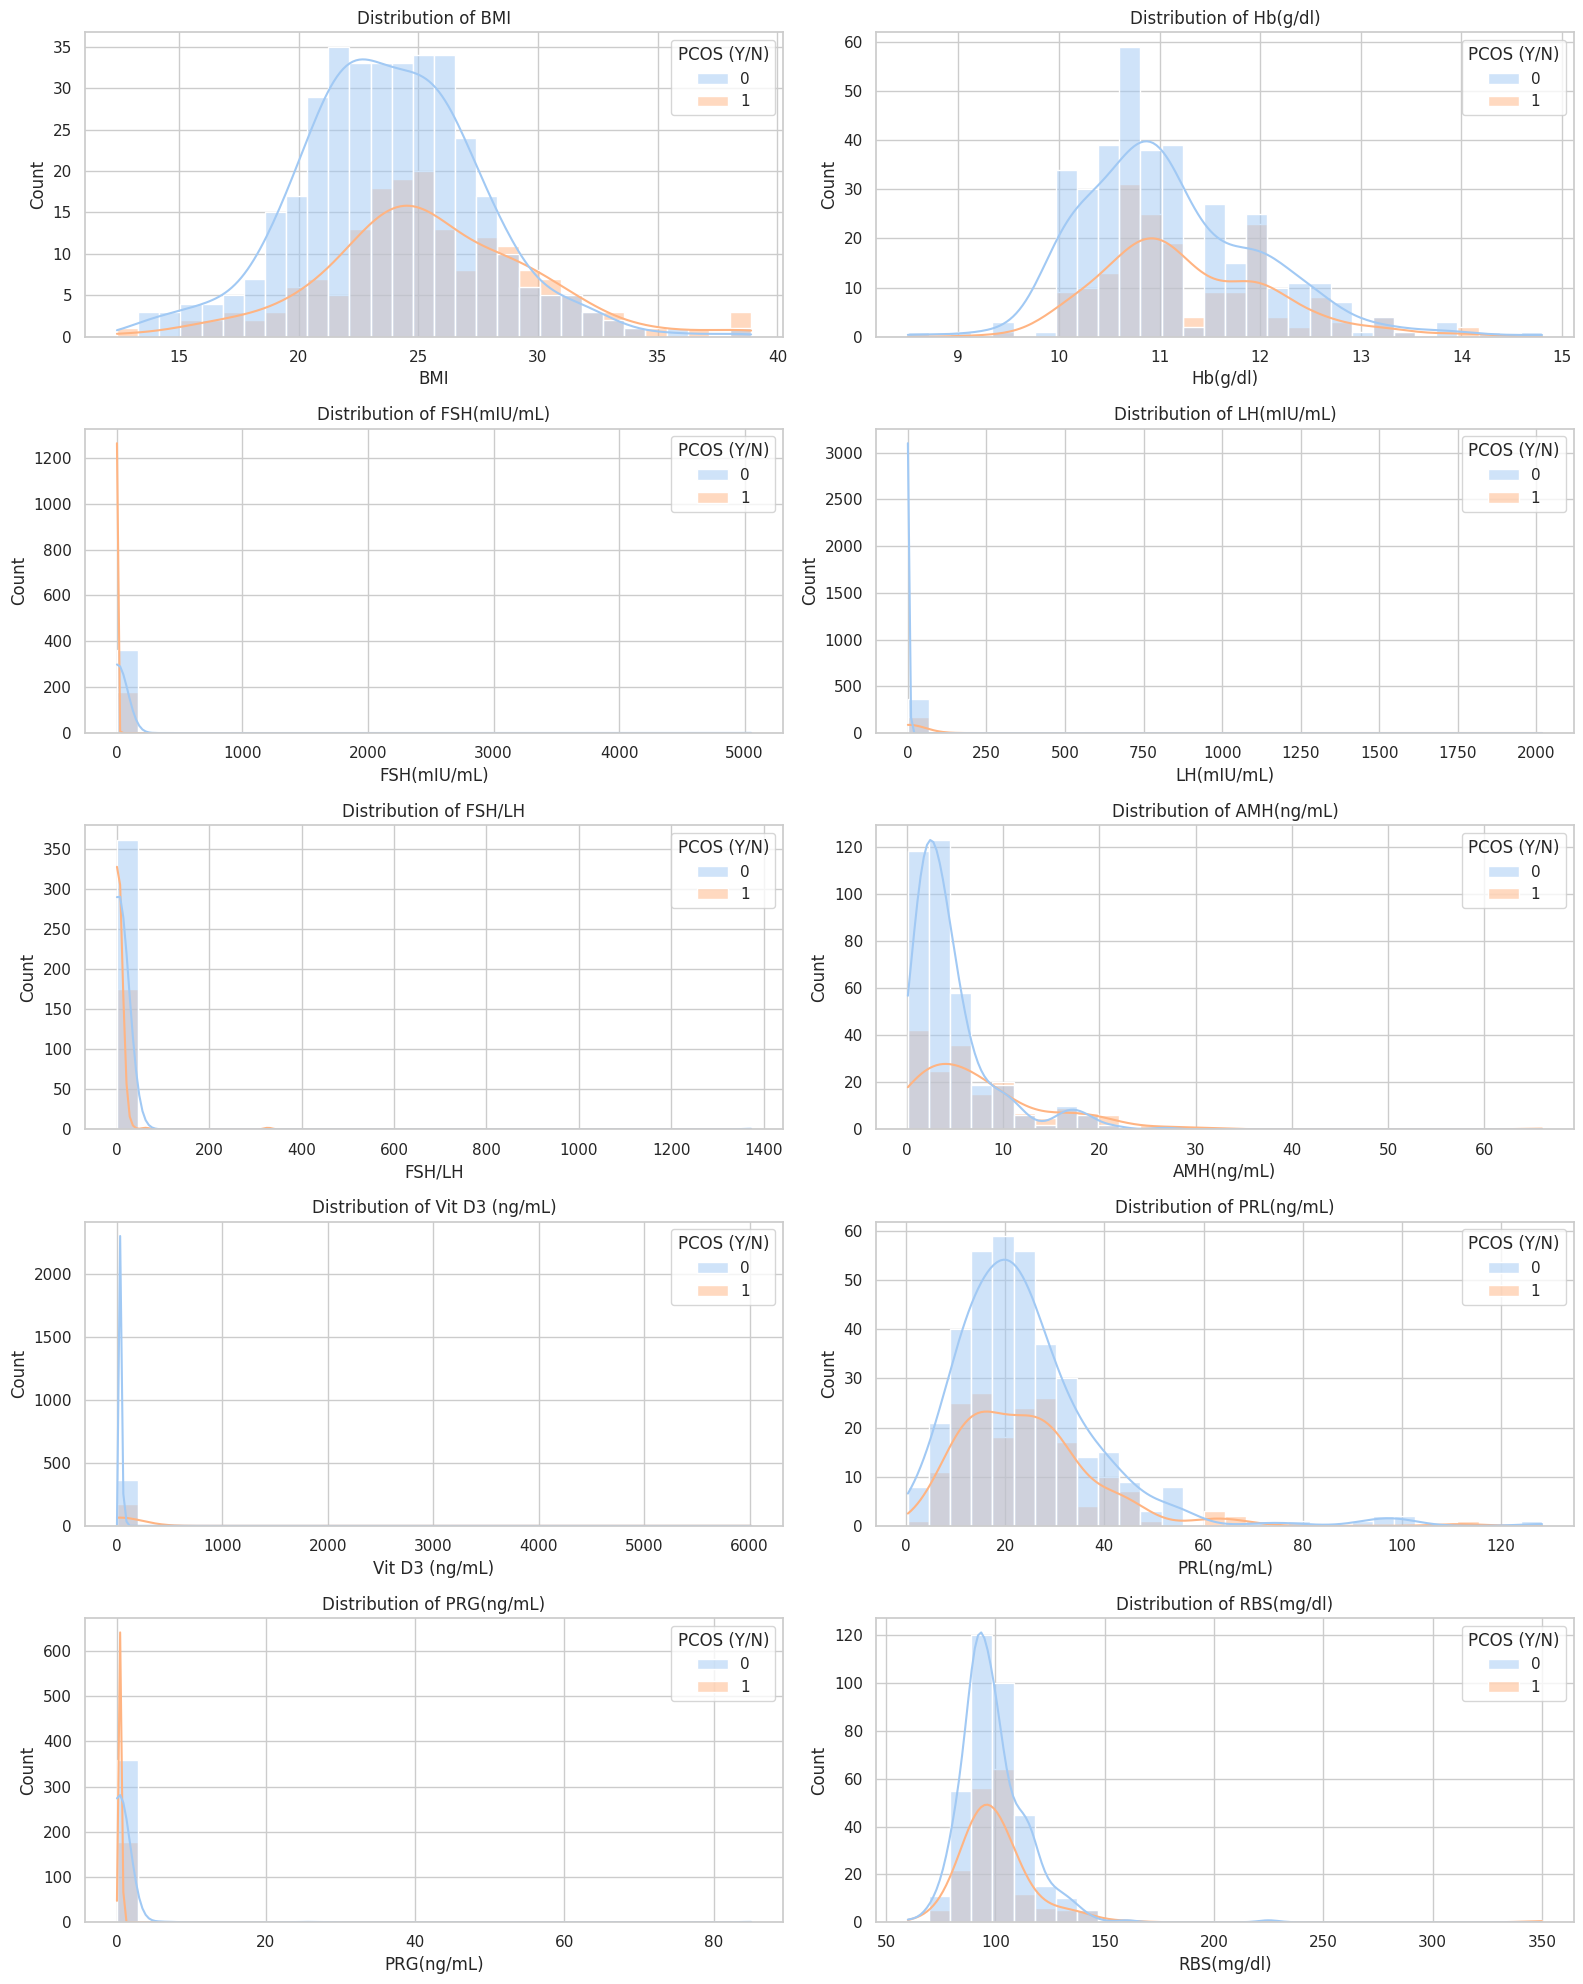

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Clean column names
data.columns = data.columns.str.strip()

# Convert object columns
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors="coerce")
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors="coerce")

# Set seaborn theme
sns.set(style="whitegrid", palette="pastel")

continuous = ["BMI", "Hb(g/dl)", "FSH(mIU/mL)", "LH(mIU/mL)", "FSH/LH",
              "AMH(ng/mL)", "Vit D3 (ng/mL)", "PRL(ng/mL)", "PRG(ng/mL)", "RBS(mg/dl)"]

# Plot 10 histograms in 5x2 grid
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(continuous):
    sns.histplot(data=data, x=col, kde=True, hue="PCOS (Y/N)", ax=axes[i], palette="pastel", bins=30)
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


## Hormonal and Metabolic Ratios (Boxplots)

<ipython-input-17-1ce7ac0bf2c2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PCOS (Y/N)", y=col, data=data, palette="Set2", ax=axes[i])
<ipython-input-17-1ce7ac0bf2c2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PCOS (Y/N)", y=col, data=data, palette="Set2", ax=axes[i])
<ipython-input-17-1ce7ac0bf2c2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PCOS (Y/N)", y=col, data=data, palette="Set2", ax=axes[i])
<ipython-input-17-1ce7ac0bf2c2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will b

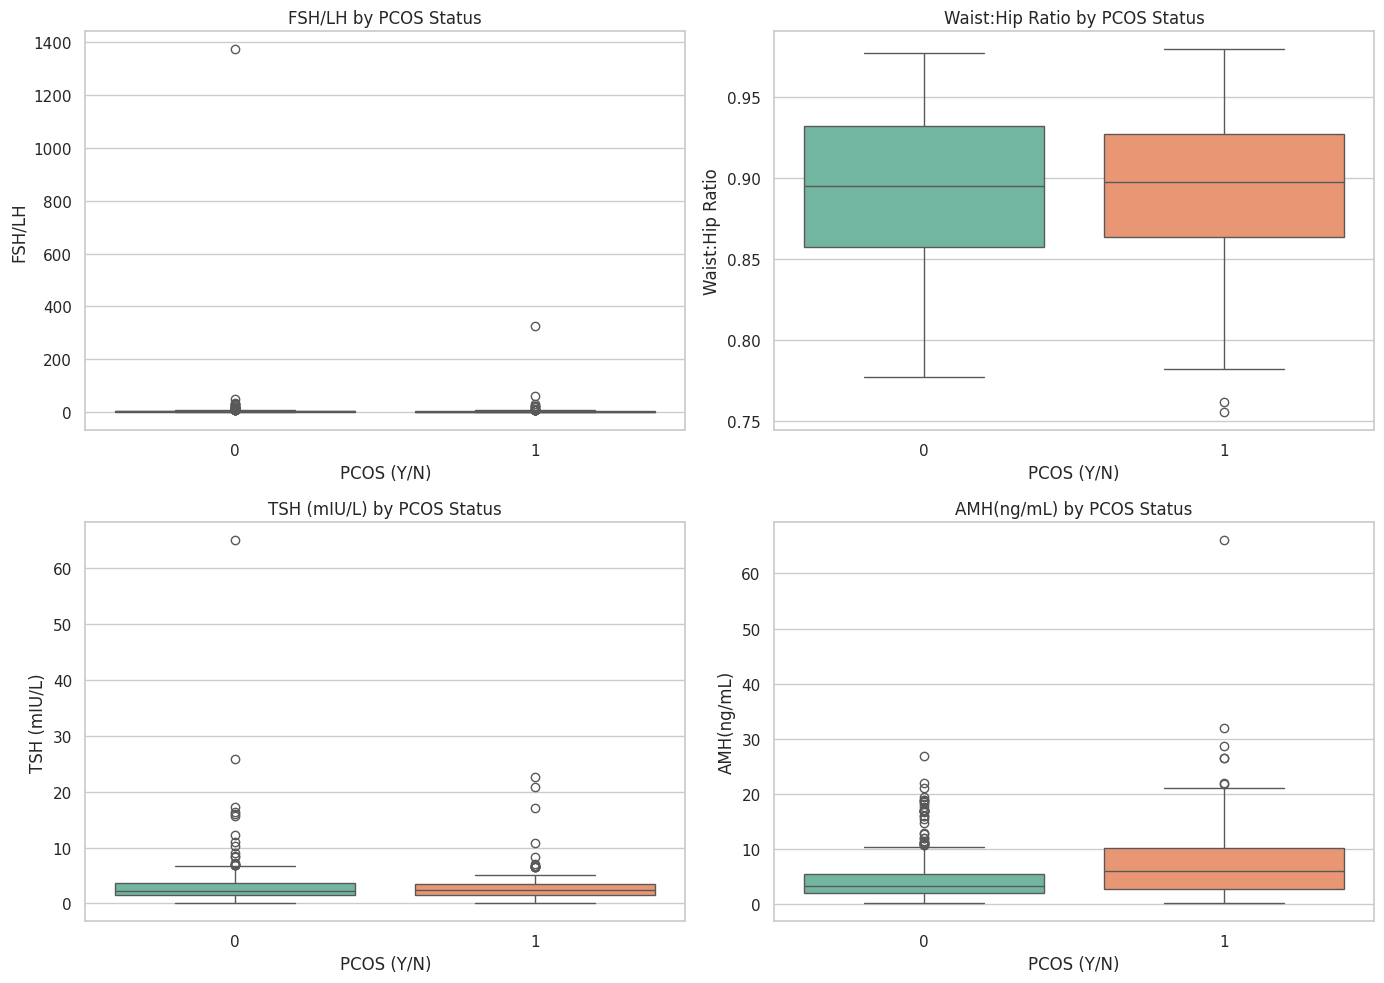

In [17]:
hormonal = ["FSH/LH", "Waist:Hip Ratio", "TSH (mIU/L)", "AMH(ng/mL)"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(hormonal):
    sns.boxplot(x="PCOS (Y/N)", y=col, data=data, palette="Set2", ax=axes[i])
    axes[i].set_title(f"{col} by PCOS Status")

plt.tight_layout()
plt.show()


##  Vital Signs & Breathing Rates

<ipython-input-18-d5527d2c3b1d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="PCOS (Y/N)", y=col, data=data, palette="pastel", ax=axes[i])
<ipython-input-18-d5527d2c3b1d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="PCOS (Y/N)", y=col, data=data, palette="pastel", ax=axes[i])
<ipython-input-18-d5527d2c3b1d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="PCOS (Y/N)", y=col, data=data, palette="pastel", ax=axes[i])
<ipython-input-18-d5527d2c3b1d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprec

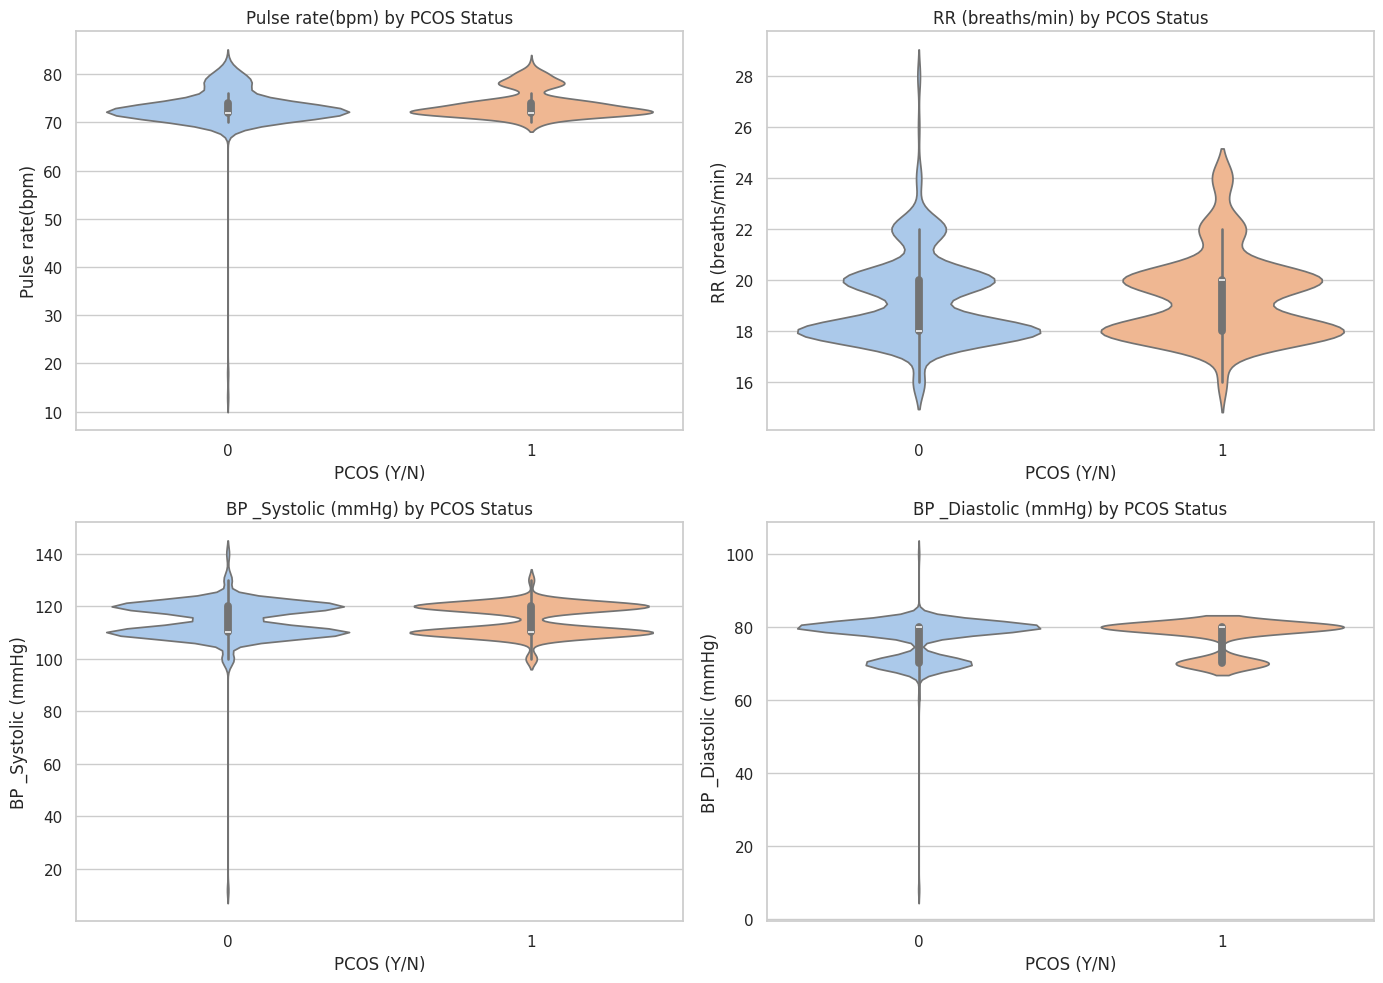

In [18]:
vitals = ["Pulse rate(bpm)", "RR (breaths/min)", "BP _Systolic (mmHg)", "BP _Diastolic (mmHg)"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(vitals):
    sns.violinplot(x="PCOS (Y/N)", y=col, data=data, palette="pastel", ax=axes[i])
    axes[i].set_title(f"{col} by PCOS Status")

plt.tight_layout()
plt.show()


## Fertility & Marital Status Factors

<ipython-input-19-ba981e5308d2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PCOS (Y/N)", y=col, data=data, palette="coolwarm", ax=axes[i])
<ipython-input-19-ba981e5308d2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PCOS (Y/N)", y=col, data=data, palette="coolwarm", ax=axes[i])
<ipython-input-19-ba981e5308d2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PCOS (Y/N)", y=col, data=data, palette="coolwarm", ax=axes[i])


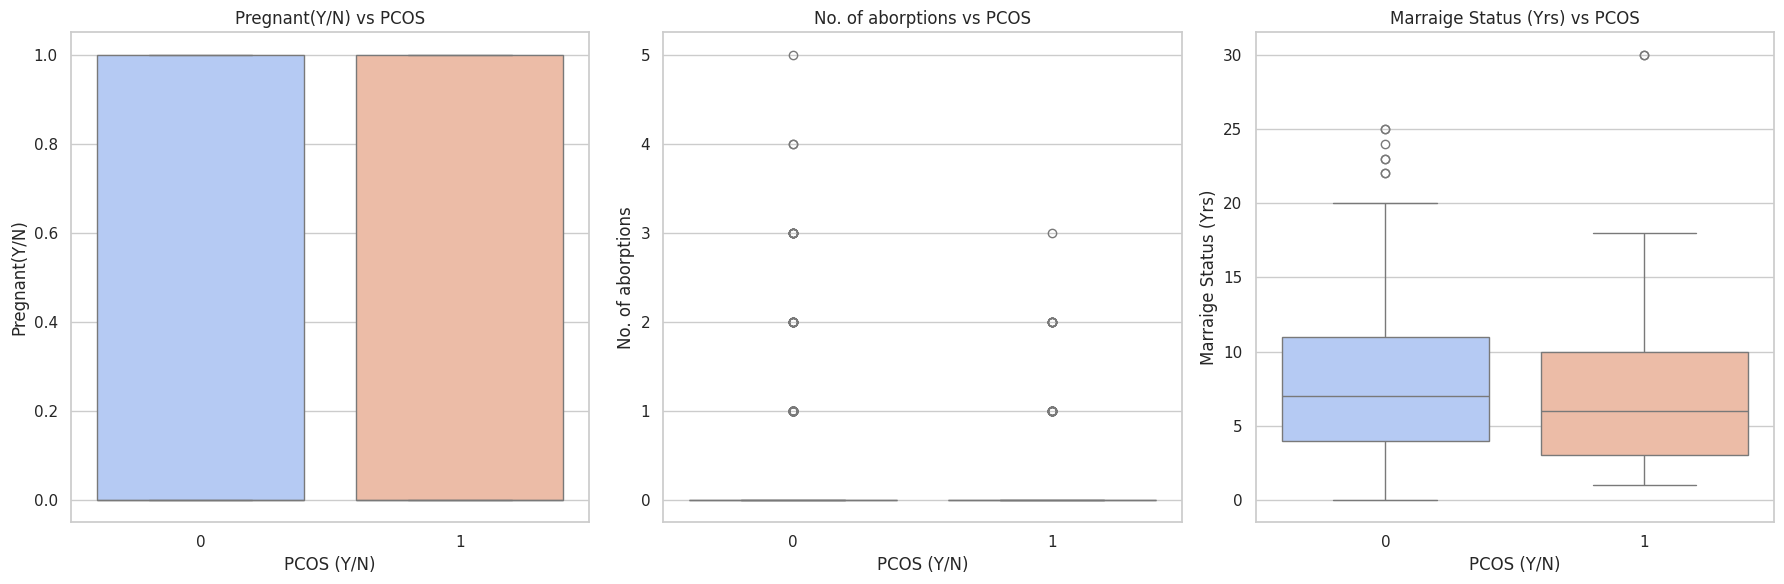

In [19]:
fertility = ["Pregnant(Y/N)", "No. of aborptions", "Marraige Status (Yrs)"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(fertility):
    sns.boxplot(x="PCOS (Y/N)", y=col, data=data, palette="coolwarm", ax=axes[i])
    axes[i].set_title(f"{col} vs PCOS")

plt.tight_layout()
plt.show()


## Lifestyle Factors (Count Plots)

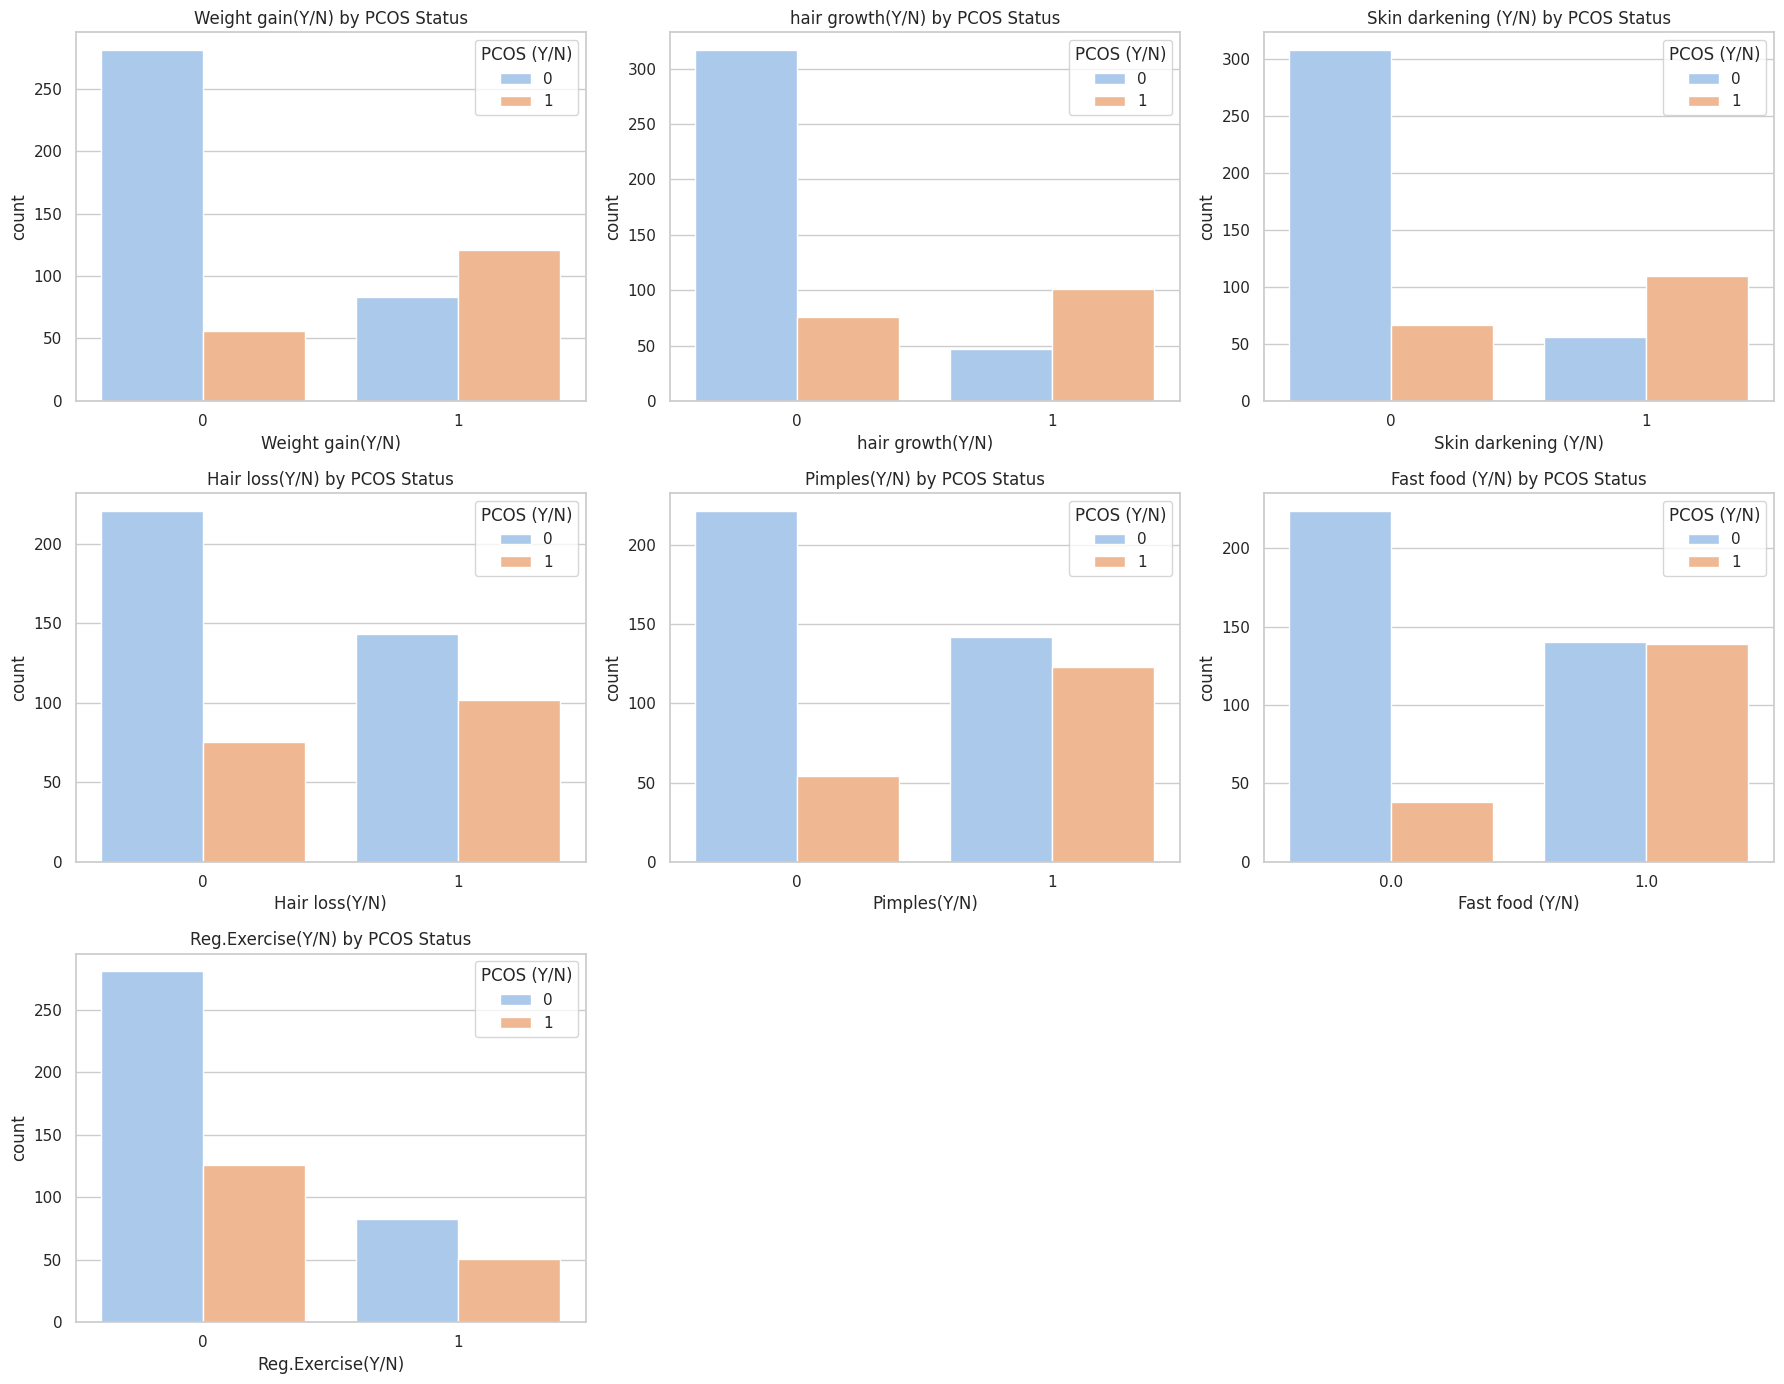

In [20]:
lifestyle = ["Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)",
             "Hair loss(Y/N)", "Pimples(Y/N)", "Fast food (Y/N)", "Reg.Exercise(Y/N)"]

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(lifestyle):
    sns.countplot(x=col, hue="PCOS (Y/N)", data=data, palette="pastel", ax=axes[i])
    axes[i].set_title(f"{col} by PCOS Status")

# Hide any unused subplots
for j in range(len(lifestyle), 9):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Just trying  Principal Component Analysis (PCA)

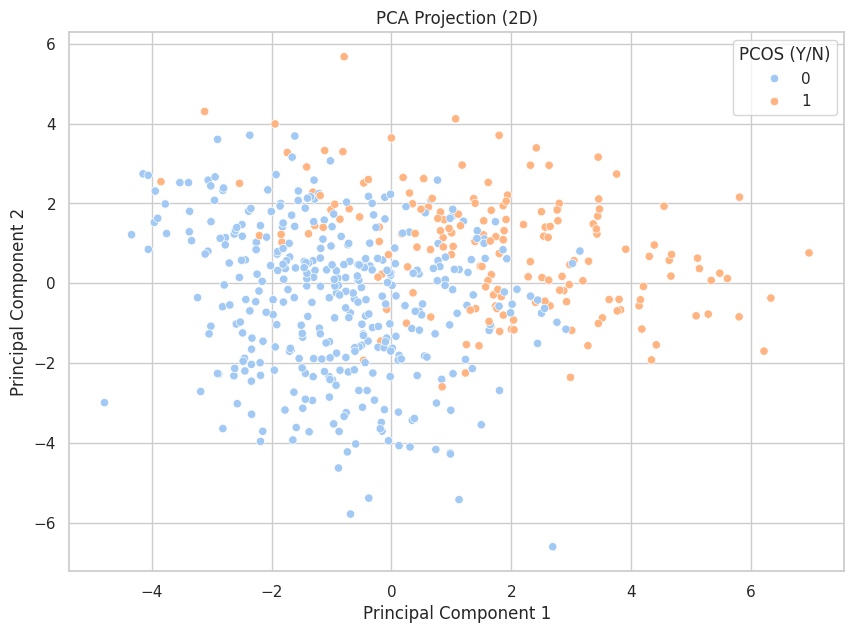

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=["PCOS (Y/N)"])
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data["PCOS (Y/N)"], palette="pastel")
plt.title("PCA Projection (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


The PCA plot above shows the separation of the two groups, PCOS (Y/N), along the first two principal components. The blue points (PCOS = 0) are mostly concentrated around the center, while the orange points (PCOS = 1) are spread across a broader range. This suggests that there are distinct patterns in the data that separate individuals with and without PCOS. The spread of both groups indicates some overlap, but the PCA highlights underlying variance that may be useful for classification.

## LET'S BUILD MODELLLLSSS

## Random Forest Model

In [22]:
#Assiging the features (X)and target(y)

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y=data["PCOS (Y/N)"]

#Splitting the data into test and training sets

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [23]:
#Fitting the RandomForestClassifier to the training set

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Making prediction and checking the test set

pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(accuracy)

0.8834355828220859


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the model
rfc = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 12],
    'criterion': ['gini', 'entropy']
}

# Run GridSearchCV (Note: n_jobs should be passed to GridSearchCV, not to the param_grid)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=7, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)


Fitting 7 folds for each of 240 candidates, totalling 1680 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
560 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
560 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

Best Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 700}
Best Cross-Validated Accuracy: 0.9179894179894179


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fit the Random Forest with best parameters from GridSearch
rfc_best = RandomForestClassifier(**grid_search.best_params_, random_state=42)
rfc_best.fit(X_train, y_train)

# Predict on the test set
predictions = rfc_best.predict(X_test)

# Calculate final test accuracy
final_accuracy = accuracy_score(y_test, predictions)
print("Final Test Accuracy:", final_accuracy)


Final Test Accuracy: 0.8895705521472392


In [26]:
classi_report = classification_report(y_test, predictions)
print(classi_report)

              precision    recall  f1-score   support

           0       0.85      0.99      0.91        95
           1       0.98      0.75      0.85        68

    accuracy                           0.89       163
   macro avg       0.91      0.87      0.88       163
weighted avg       0.90      0.89      0.89       163



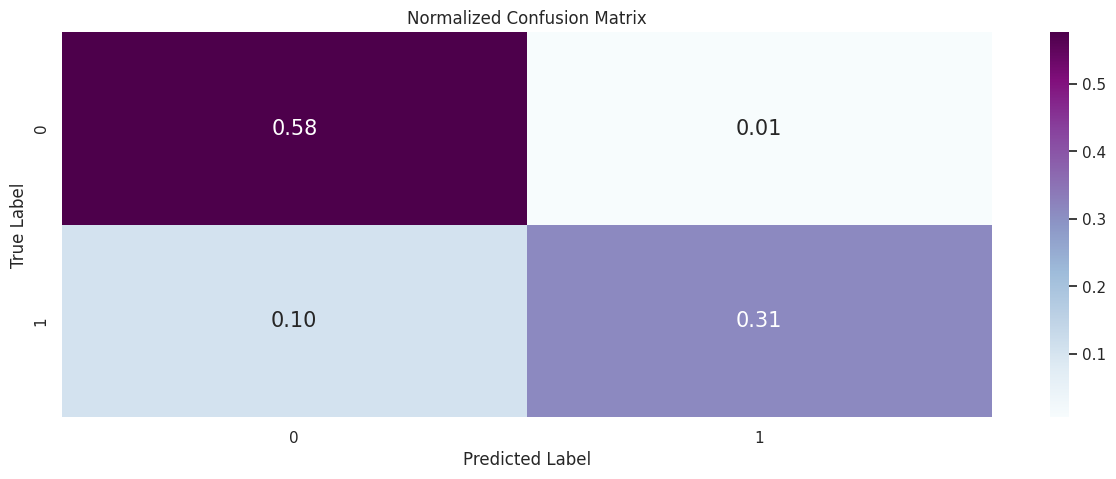

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix and plot
plt.subplots(figsize=(15, 5))
cf_matrix = confusion_matrix(y_test, predictions)

# Normalized heatmap
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt=".2f",
            annot_kws={'size': 15}, cmap='BuPu')  # Changed here
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## NEURAL NETWORK HERE

In [28]:
#Assiging the features (X)and target(y)

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y=data["PCOS (Y/N)"]

#Splitting the data into test and training sets

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    Dense(32, activation='relu'),  # Second hidden layer
    Dense(1, activation='sigmoid')  # Output layer (assuming binary classification)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6727 - loss: 0.5932 - val_accuracy: 0.8528 - val_loss: 0.4743
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8253 - loss: 0.4488 - val_accuracy: 0.8773 - val_loss: 0.3990
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8535 - loss: 0.3803 - val_accuracy: 0.8834 - val_loss: 0.3526
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8585 - loss: 0.3336 - val_accuracy: 0.8773 - val_loss: 0.3217
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8749 - loss: 0.2847 - val_accuracy: 0.8773 - val_loss: 0.3062
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8960 - loss: 0.2642 - val_accuracy: 0.8773 - val_loss: 0.2928
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9065 - loss: 0.2281 - val_accuracy: 0.8712 - val_loss: 0.2866
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9474 - loss: 0.1986 - val_accuracy: 0.8712 - val_loss: 0.2848
E

In [30]:
pred_probs = model.predict(X_test_scaled)

# Convert probabilities to class labels (0 or 1)
predictions = (pred_probs > 0.5).astype(int).flatten()  # Flatten to match y_test shape

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [31]:
from sklearn.metrics import classification_report
classi_report = classification_report(y_test, predictions)
print(classi_report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       113
           1       0.80      0.82      0.81        50

    accuracy                           0.88       163
   macro avg       0.86      0.87      0.86       163
weighted avg       0.88      0.88      0.88       163



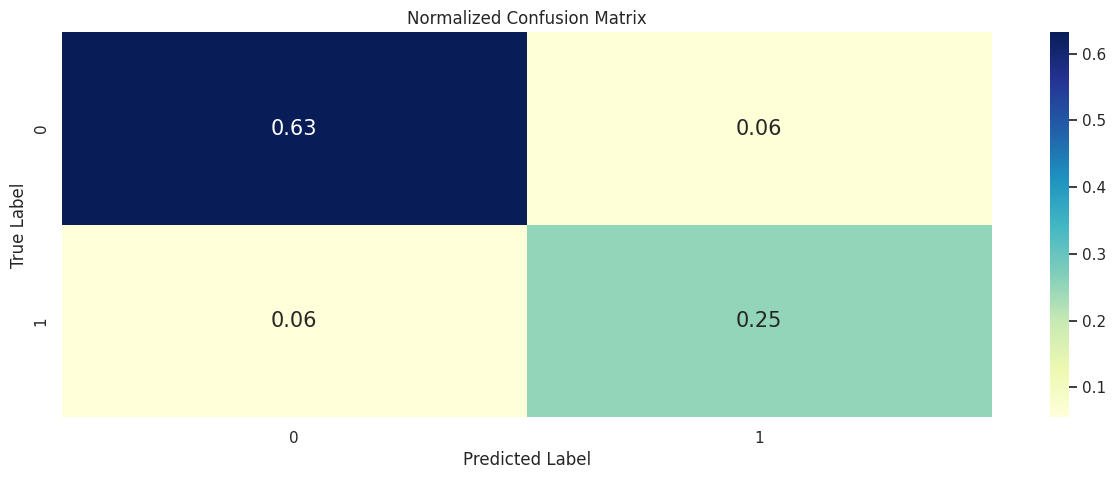

In [32]:
plt.subplots(figsize=(15, 5))
cf_matrix = confusion_matrix(y_test, predictions)

# Plot with a soft pastel gradient
sns.heatmap(cf_matrix / np.sum(cf_matrix),
            annot=True, fmt=".2f",
            annot_kws={'size': 15},
            cmap='YlGnBu')  # 💡 changed color here
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## SVM

In [33]:
#Assiging the features (X)and target(y)

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y=data["PCOS (Y/N)"]

## ExtraTreeClassifier Feature Importance Plot

<ipython-input-34-1bcc80373478>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="Blues_r")  # 💡 Changed color palette


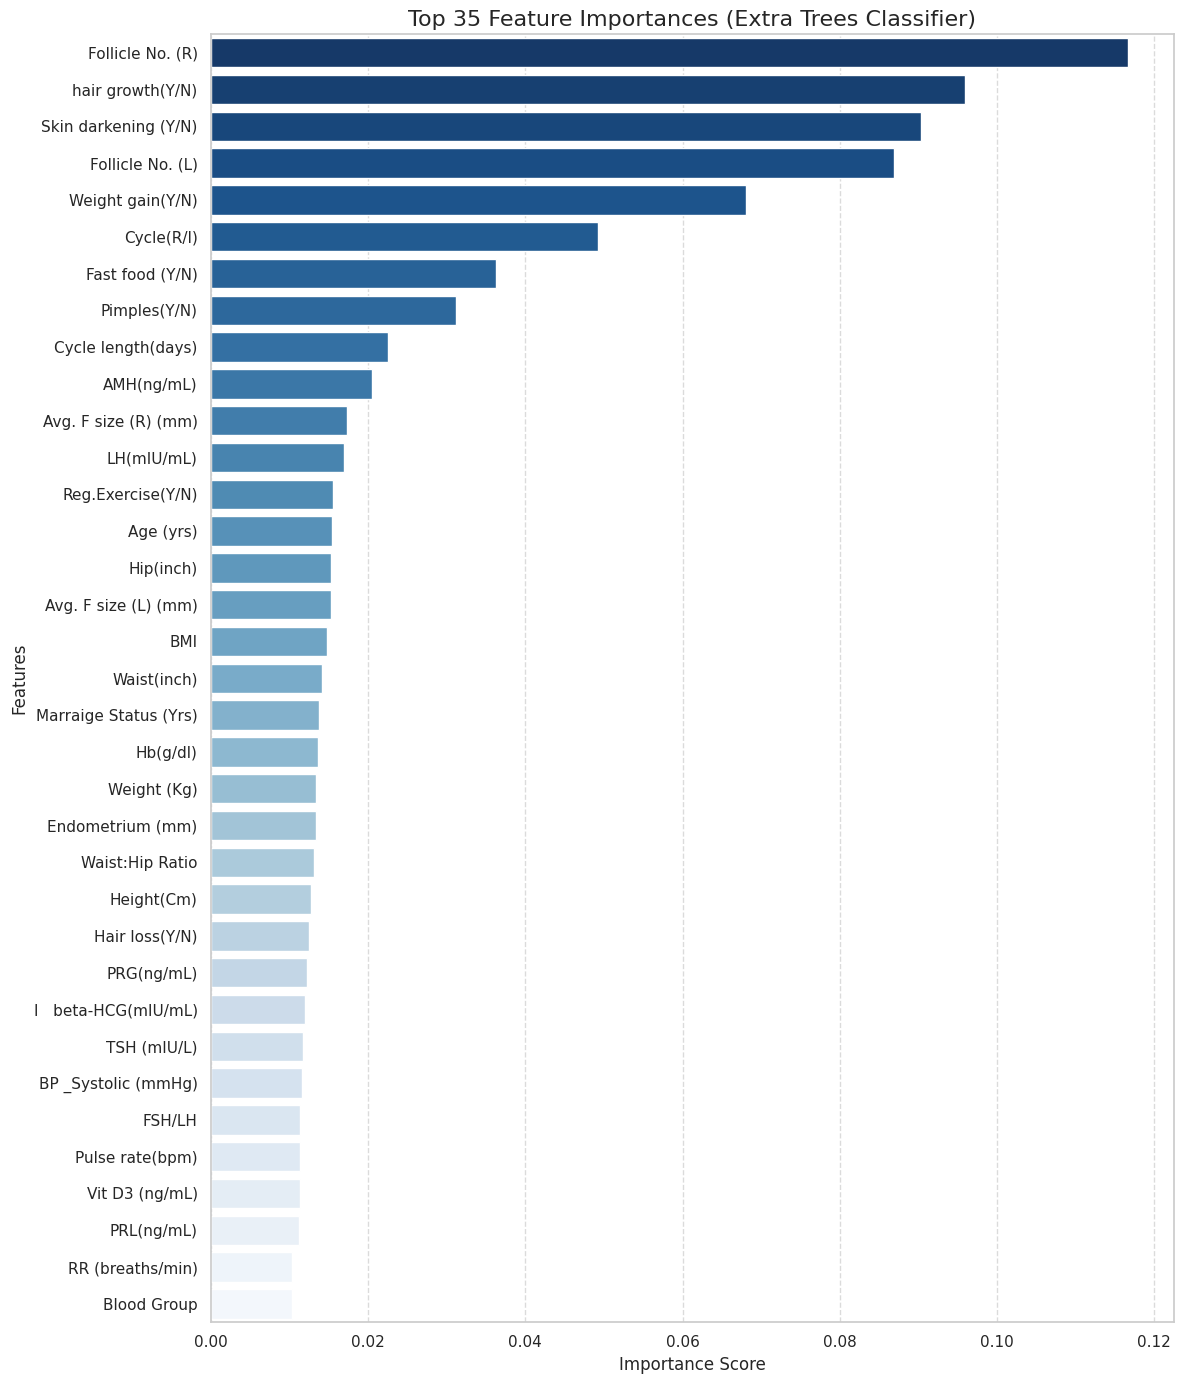

In [34]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Fit ExtraTreesClassifier
model = ExtraTreesClassifier(random_state=42)
model.fit(X, y)

# Create feature importance series
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = feat_importances.nlargest(35)

# Plot
plt.figure(figsize=(12, 14))
sns.barplot(x=top_features.values, y=top_features.index, palette="Blues_r")  # 💡 Changed color palette
plt.title("Top 35 Feature Importances (Extra Trees Classifier)", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
# Get top 9 important features
top_9_features = feat_importances.nlargest(9)

# Filter original dataset using those features
df_top9 = data[top_9_features.index]

# Display the new DataFrame
df_top9.head()


,Follicle No. (R),hair growth(Y/N),Skin darkening (Y/N),Follicle No. (L),Weight gain(Y/N),Cycle(R/I),Fast food (Y/N),Pimples(Y/N),Cycle length(days)
0,3,0,0,3,0,2,1.0,0,5
1,5,0,0,3,0,2,0.0,0,5
2,15,0,0,13,0,2,1.0,1,5
3,2,0,0,2,0,2,0.0,0,5
4,4,0,0,3,0,2,0.0,0,5


## Check correlation among top features

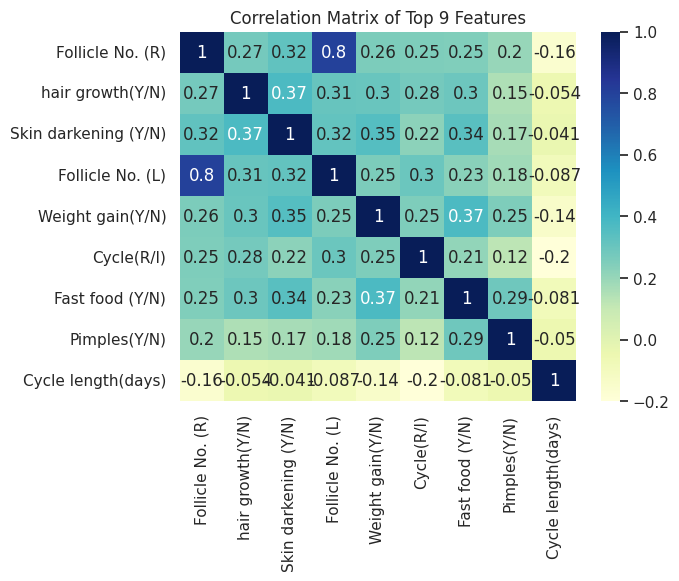

In [36]:
sns.heatmap(df_top9.corr(), annot=True, cmap='YlGnBu')
plt.title("Correlation Matrix of Top 9 Features")
plt.show()


Re-train a lightweight model on just these features for comparison

In [37]:
from sklearn.ensemble import RandomForestClassifier
model_top9 = RandomForestClassifier(random_state=42)
model_top9.fit(df_top9, y)


RandomForestClassifier(random_state=42)

##  Class Distribution Visualization with Labels

<ipython-input-38-d242197b5d85>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="labels", data=df, palette="pastel")


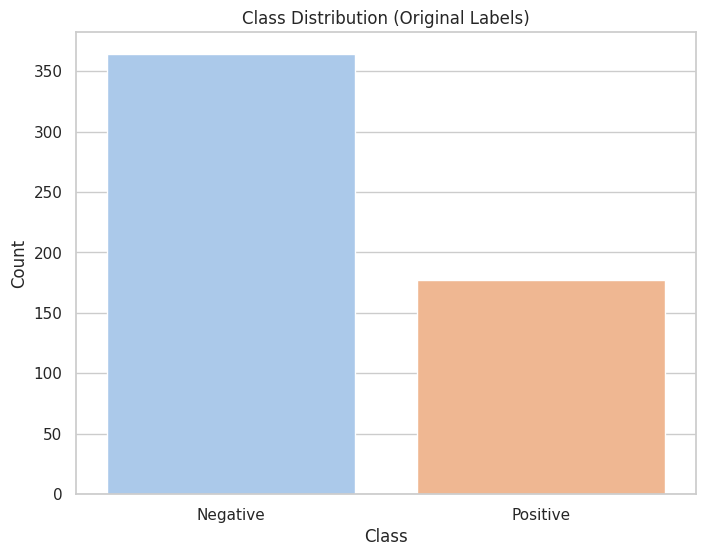

Label Mapping: {0: 'Negative', 1: 'Positive'}


In [38]:
# Map for label meanings
map_characters = {0: 'Negative', 1: 'Positive'}

# Create a DataFrame for labels
df = pd.DataFrame({"labels": y})

# Count label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="labels", data=df, palette="pastel")

# Set axis labels and ticks using the map
plt.title("Class Distribution (Original Labels)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=[map_characters[0], map_characters[1]])

# Save plot
plt.savefig('SVM-un-balance.png', bbox_inches='tight')
plt.show()

# Print label mapping
print("Label Mapping:", map_characters)

## Combining ADASYN oversampling with Edited Nearest Neighbours (ENN) undersampling to balance the dataset

New balance of 1 and 0 classes (%):
PCOS (Y/N)
1    50.990991
0    49.009009
Name: proportion, dtype: float64


<ipython-input-39-ac3a8eaa7257>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="PCOS (Y/N)", data=y_sm, palette="pastel")


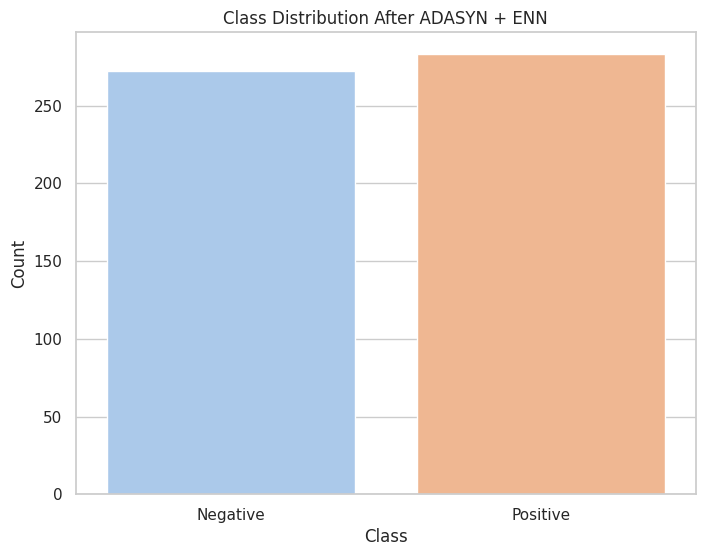

Label Mapping: {0: 'Negative', 1: 'Positive'}


In [39]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define label mapping
map_characters = {0: 'Negative', 1: 'Positive'}

# Step 1: Oversampling using ADASYN
ada = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_ada, y_ada = ada.fit_resample(df_top9, y)  # ✅ Replaced df_again with df_top9

# Step 2: Undersampling using ENN
enn = EditedNearestNeighbours(sampling_strategy='all', n_neighbors=3)
X_sm, y_sm = enn.fit_resample(X_ada, y_ada)

# Convert to DataFrames
X_sm = pd.DataFrame(X_sm, columns=df_top9.columns)
y_sm = pd.DataFrame(y_sm, columns=['PCOS (Y/N)'])

# Check new class distribution
print('New balance of 1 and 0 classes (%):')
print(y_sm['PCOS (Y/N)'].value_counts(normalize=True) * 100)

# Plot balanced class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="PCOS (Y/N)", data=y_sm, palette="pastel")
plt.title("Class Distribution After ADASYN + ENN")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=[map_characters[0], map_characters[1]])
plt.savefig('SVM-Balanced.png', bbox_inches='tight')
plt.show()

# Print label mapping
print("Label Mapping:", map_characters)


Data Splitting

In [40]:
#Splitting the data into test and training sets

X_train,X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.2, random_state=12)

In [41]:
y_train = np.array(y_train)
y_test = np.array(y_test)

trains the SVC model using your training data (X_train, y_train) with the RBF kernel and the specified hyperparameters.

In [42]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with linear kernel and C=1.0
linear_svc1000=SVC(kernel='rbf', C=1000.0, probability=True, gamma='scale')


# fit classifier to training set
linear_svc1000.fit(X_train.values,np.ravel(y_train))

SVC(C=1000.0, probability=True)

This code uses Deepchecks, a model validation tool, to automatically run 100+ sanity and quality checks on your SVC model.
It converts your training and test data into a Deepchecks Dataset format, then runs the full validation suite to assess data integrity, model performance, overfitting, and bias.
The results can be visualized inline or exported as a full HTML report.
This provides a comprehensive diagnostic report without manually writing dozens of checks.

In [43]:
!pip install evidently --upgrade

In [44]:
!pip install evidently_classification_report

ERROR: Could not find a version that satisfies the requirement evidently_classification_report (from versions: none)
ERROR: No matching distribution found for evidently_classification_report


✅ Accuracy Score: 0.963963963963964
✅ Precision Score: 0.96875
✅ Recall Score: 0.96875
✅ F1 Score: 0.96875

📄 Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

    Negative       0.96      0.96      0.96        47
    Positive       0.97      0.97      0.97        64

    accuracy                           0.96       111
   macro avg       0.96      0.96      0.96       111
weighted avg       0.96      0.96      0.96       111



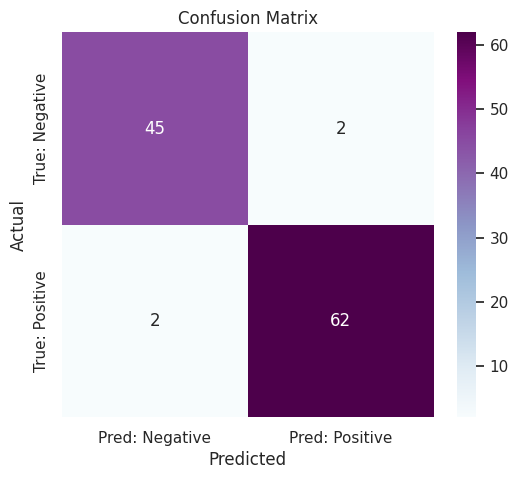

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


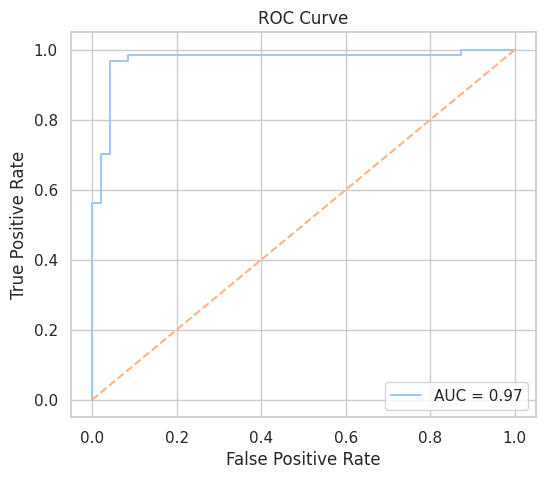

In [45]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Metrics
y_pred = linear_svc1000.predict(X_test)

print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("✅ Precision Score:", precision_score(y_test, y_pred))
print("✅ Recall Score:", recall_score(y_test, y_pred))
print("✅ F1 Score:", f1_score(y_test, y_pred))

# 2. Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# 3. Confusion Matrix (visual)
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='BuPu',
            xticklabels=["Pred: Negative", "Pred: Positive"],
            yticklabels=["True: Negative", "True: Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. ROC Curve
y_probs = linear_svc1000.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


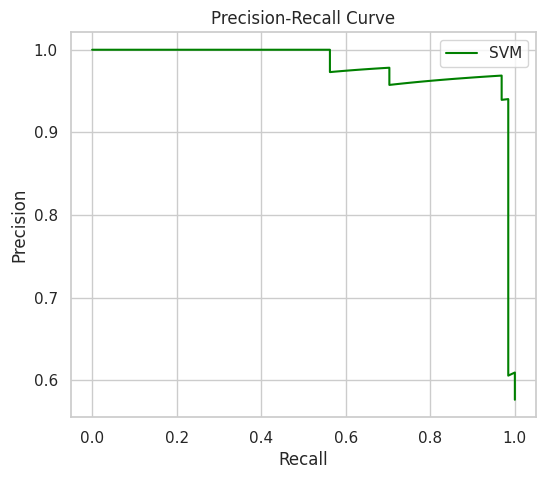

In [46]:
from sklearn.metrics import precision_recall_curve

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', label='SVM')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
train_score = linear_svc1000.score(X_train, y_train)
test_score = linear_svc1000.score(X_test, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")


Training Accuracy: 0.9955
Test Accuracy: 0.9640


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr

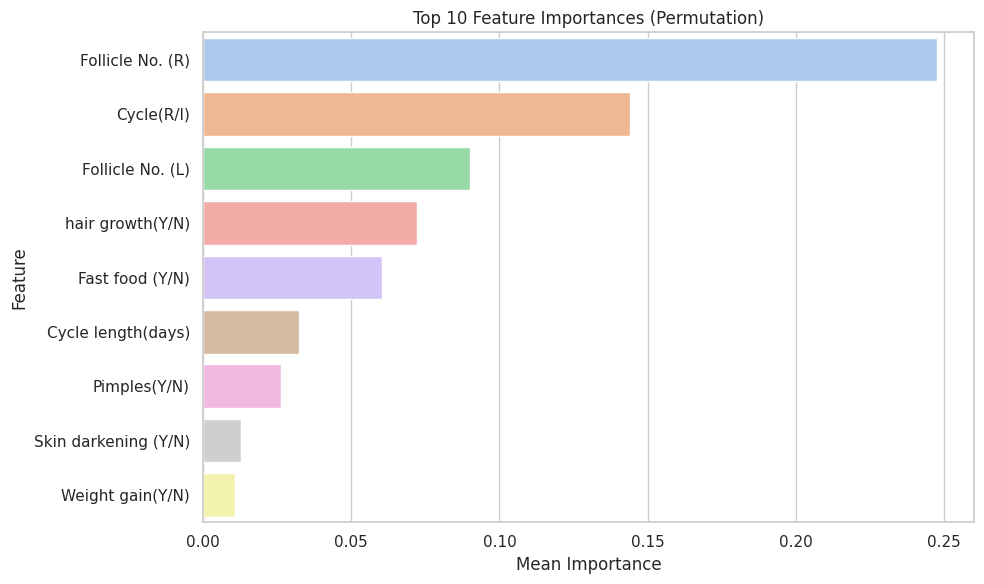

In [48]:
from sklearn.inspection import permutation_importance

result = permutation_importance(linear_svc1000, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Visualize top features
import pandas as pd
import numpy as np

importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), y='Feature', x='Importance', palette='pastel')
plt.title('Top 10 Feature Importances (Permutation)')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [49]:
#TabNet
!pip install pytorch-tabnet --quiet
!pip install category_encoders --quiet


In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder

# Combine X and y for encoding
df_full = pd.concat([X_sm, y_sm], axis=1)

# Optional: convert target to flat array
y = df_full['PCOS (Y/N)'].values

# One-hot encode categorical (if any, here assumed none for now)
encoder = OneHotEncoder(cols=[], use_cat_names=True)
df_encoded = encoder.fit_transform(df_full.drop('PCOS (Y/N)', axis=1))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Final X and y
X = X_scaled
y = y.astype(int)

# Split again (TabNet works better with numpy)
X_train_tabnet, X_test_tabnet, y_train_tabnet, y_test_tabnet = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, classification_report

tabnet_model = TabNetClassifier(verbose=1, seed=42)

# Fit the model
tabnet_model.fit(
    X_train=X_train_tabnet, y_train=y_train_tabnet,
    eval_set=[(X_train_tabnet, y_train_tabnet), (X_test_tabnet, y_test_tabnet)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00244 | train_accuracy: 0.52252 | test_accuracy: 0.53153 |  0:00:00s
epoch 1  | loss: 0.75658 | train_accuracy: 0.60135 | test_accuracy: 0.61261 |  0:00:00s
epoch 2  | loss: 0.65962 | train_accuracy: 0.64865 | test_accuracy: 0.65766 |  0:00:00s
epoch 3  | loss: 0.60391 | train_accuracy: 0.67117 | test_accuracy: 0.65766 |  0:00:00s
epoch 4  | loss: 0.54839 | train_accuracy: 0.70946 | test_accuracy: 0.66667 |  0:00:00s
epoch 5  | loss: 0.55664 | train_accuracy: 0.73649 | test_accuracy: 0.67568 |  0:00:01s
epoch 6  | loss: 0.49591 | train_accuracy: 0.74099 | test_accuracy: 0.73874 |  0:00:01s
epoch 7  | loss: 0.49032 | train_accuracy: 0.77027 | test_accuracy: 0.77477 |  0:00:01s
epoch 8  | loss: 0.431   | train_accuracy: 0.79955 | test_accuracy: 0.76577 |  0:00:01s
epoch 9  | loss: 0.43822 | train_accuracy: 0.79955 | test_accuracy: 0.76577 |  0:00:01s
epoch 10 | loss: 0.42521 | train_accuracy: 0.80856 | test_accuracy: 0.77477 |  0:00:01s
epoch 11 | loss: 0.35411 | train

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [52]:
# Predict
y_pred_tabnet = tabnet_model.predict(X_test_tabnet)

# Metrics
print("✅ Accuracy:", accuracy_score(y_test_tabnet, y_pred_tabnet))
print("\n📄 Classification Report:\n", classification_report(y_test_tabnet, y_pred_tabnet))


✅ Accuracy: 0.972972972972973

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        61
           1       0.96      0.98      0.97        50

    accuracy                           0.97       111
   macro avg       0.97      0.97      0.97       111
weighted avg       0.97      0.97      0.97       111



<ipython-input-53-5ffedc870268>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature', palette='viridis')


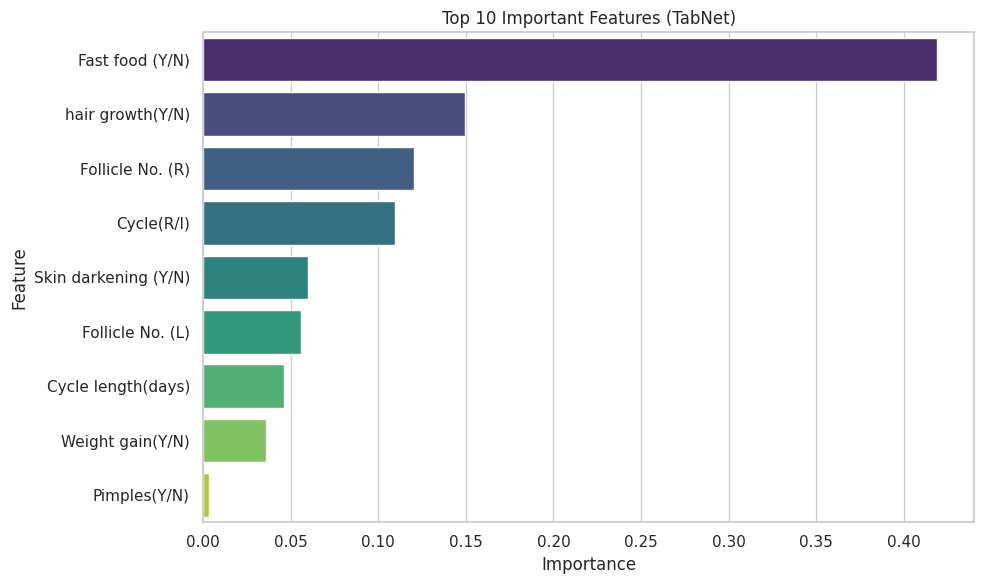

In [53]:
import matplotlib.pyplot as plt

# Plot feature importance
importances = tabnet_model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': df_encoded.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Important Features (TabNet)")
plt.tight_layout()
plt.show()


In [54]:
!pip install lightgbm --quiet


In [55]:
from sklearn.model_selection import train_test_split

# Use correctly resampled balanced data
X = X_sm  # This is the balanced feature set (555 rows)
y = y_sm["PCOS (Y/N)"]  # This is the balanced label column (555 rows)

# Split the data now (this will work)
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

lgbm_model.fit(X_train_lgb, y_train_lgb)

# Evaluate
y_pred_lgb = lgbm_model.predict(X_test_lgb)
print("✅ Accuracy:", accuracy_score(y_test_lgb, y_pred_lgb))
print("\n📄 Classification Report:\n", classification_report(y_test_lgb, y_pred_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 233, number of negative: 211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 444, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524775 -> initscore=0.099180
[LightGBM] [Info] Start training from score 0.099180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

<ipython-input-57-b363b9ae77ee>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette='YlGnBu')


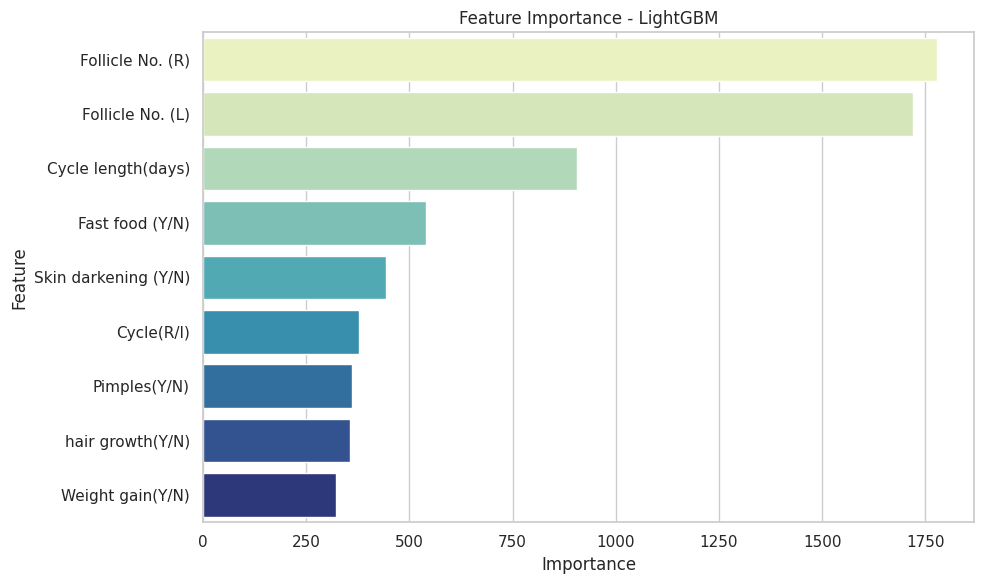

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
feat_imp = lgbm_model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='YlGnBu')
plt.title('Feature Importance - LightGBM')
plt.tight_layout()
plt.show()


In [58]:
#EXB
!pip install interpret --quiet

In [59]:
from sklearn.model_selection import train_test_split

X = X_sm
y = y_sm["PCOS (Y/N)"]

# Split for training and testing
X_train_ebm, X_test_ebm, y_train_ebm, y_test_ebm = train_test_split(X, y, test_size=0.2, random_state=42)


In [60]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train_ebm, y_train_ebm)

# Predict
y_pred_ebm = ebm.predict(X_test_ebm)

# Evaluate
print("✅ Accuracy:", accuracy_score(y_test_ebm, y_pred_ebm))
print("\n📄 Classification Report:\n", classification_report(y_test_ebm, y_pred_ebm))


✅ Accuracy: 0.9819819819819819

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        61
           1       0.98      0.98      0.98        50

    accuracy                           0.98       111
   macro avg       0.98      0.98      0.98       111
weighted avg       0.98      0.98      0.98       111



In [61]:
from interpret import show

# Global feature importance (HTML dashboard)
ebm_global = ebm.explain_global()
show(ebm_global)


In [62]:
#SHAP
!pip install shap --quiet

In [63]:
import shap
import matplotlib.pyplot as plt

# Explain the model's predictions using SHAP
explainer = shap.Explainer(lgbm_model, X_train_lgb)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_lgb)


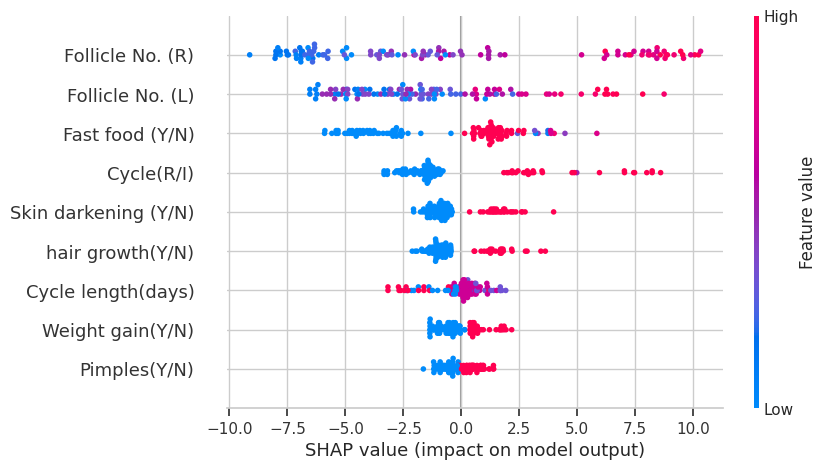

In [64]:
shap.plots.beeswarm(shap_values)

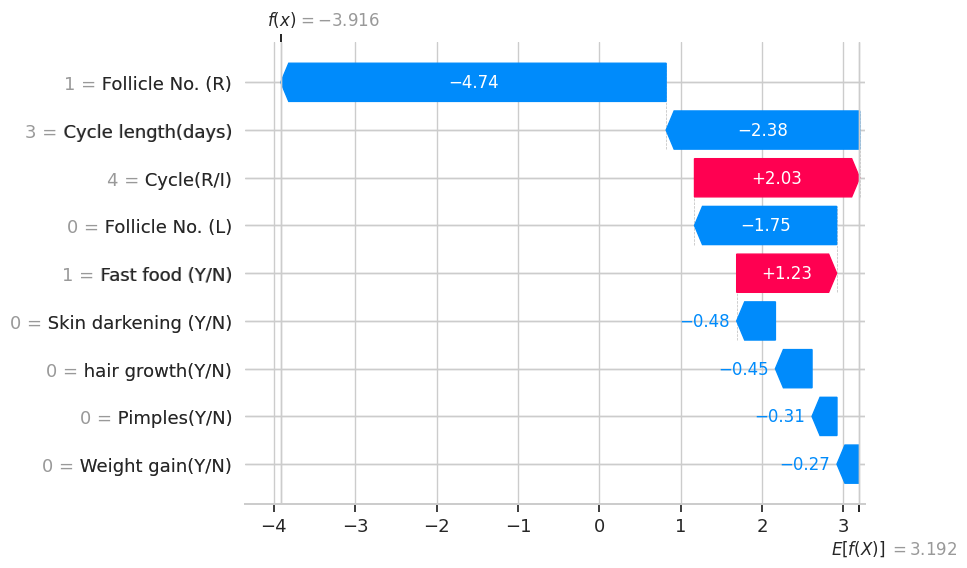

In [65]:
# Pick a specific patient (row)
row = 10
shap.plots.waterfall(shap_values[row])


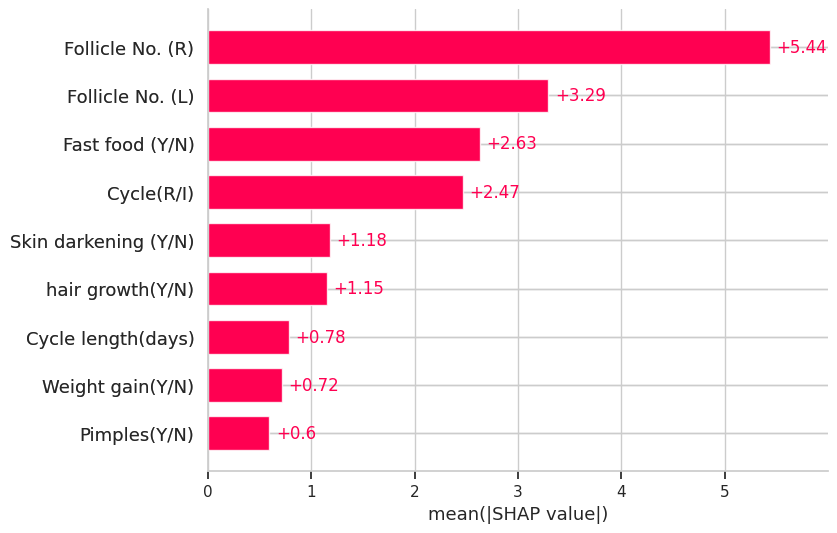

In [66]:
shap.plots.bar(shap_values)

ExactExplainer explainer: 112it [00:13,  7.58it/s]


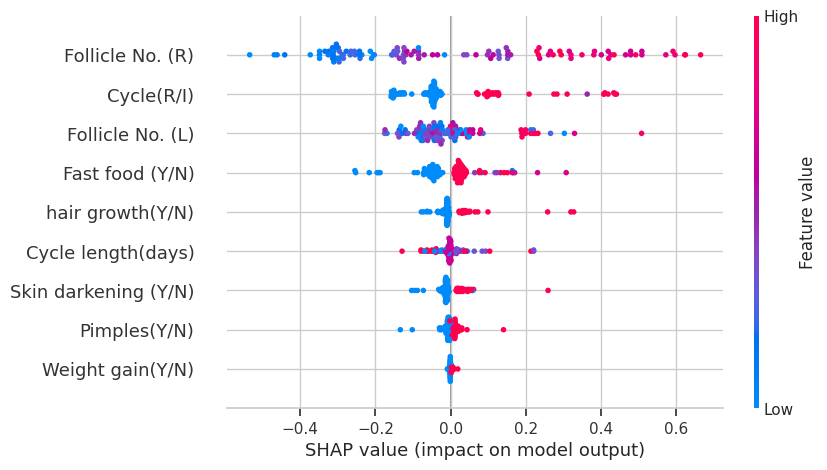

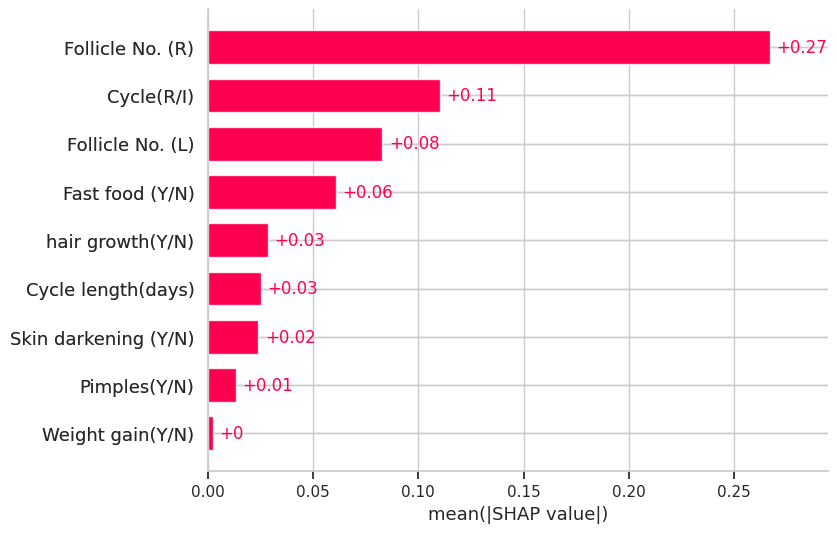

 99%|===================| 220/222 [00:11<00:00]       

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was nan, while the model output was 0.673439. If this difference is acceptable you can set check_additivity=False to disable this check.

In [67]:
import shap

# Create SHAP Explainer for EBM using prediction function
explainer_ebm = shap.Explainer(ebm.predict, X_test_ebm)
shap_values_ebm = explainer_ebm(X_test_ebm)

# SHAP Summary Plot
shap.plots.beeswarm(shap_values_ebm, max_display=10)
shap.plots.bar(shap_values_ebm, max_display=10)

explainer_rf = shap.Explainer(rfc_best, X_test)
shap_values_rf = explainer_rf(X_test)

shap.plots.beeswarm(shap_values_rf, max_display=10)
shap.plots.bar(shap_values_rf, max_display=10)

explainer_tabnet = shap.Explainer(tabnet_model.predict, X_test_tabnet)
shap_values_tabnet = explainer_tabnet(X_test_tabnet)

shap.plots.beeswarm(shap_values_tabnet, max_display=10)
shap.plots.bar(shap_values_tabnet, max_display=10)

# Use KernelExplainer for black-box models like SVM
explainer_svm = shap.Explainer(linear_svc1000.predict_proba, X_train)
shap_values_svm = explainer_svm(X_test)

shap.plots.beeswarm(shap_values_svm[:, 1], max_display=10)
shap.plots.bar(shap_values_svm[:, 1], max_display=10)


In [1]:
import shap
import matplotlib.pyplot as plt

# SHAP-safe model configurations
models_to_explain = [
    {
        "name": "EBM",
        "model": ebm.predict,
        "X_test": X_test_ebm,
        "type": "function"
    },
    {
        "name": "RandomForest",
        "model": rfc_best,
        "X_test": X_test,
        "type": "tree"
    },
    {
        "name": "TabNet",
        "model": tabnet_model.predict,
        "X_test": X_test_tabnet,
        "type": "function"
    },
    {
        "name": "SVM",
        "model": linear_svc1000.predict_proba,
        "X_test": X_test,
        "type": "kernel",
        "class_index": 1
    }
]

for model_info in models_to_explain:
    name = model_info["name"]
    model = model_info["model"]
    X = model_info["X_test"]
    explainer_type = model_info["type"]

    print(f"🔍 Running SHAP for {name}...")

    try:
        if explainer_type == "tree":
            explainer = shap.Explainer(model, X, check_additivity=False)
            shap_values = explainer(X)
        elif explainer_type == "function":
            explainer = shap.Explainer(model, X, check_additivity=False)
            shap_values = explainer(X)
        elif explainer_type == "kernel":
            explainer = shap.Explainer(model, X, check_additivity=False)
            shap_values = explainer(X)[:, model_info.get("class_index", 1)]

        # Beeswarm Plot
        plt.figure()
        shap.plots.beeswarm(shap_values, max_display=10, show=False)
        plt.title(f"SHAP Beeswarm Plot - {name}")
        plt.savefig(f"shap_beeswarm_{name}.png", bbox_inches='tight')
        plt.show()

        # Bar Plot
        plt.figure()
        shap.plots.bar(shap_values, max_display=10, show=False)
        plt.title(f"SHAP Bar Plot - {name}")
        plt.savefig(f"shap_bar_{name}.png", bbox_inches='tight')
        plt.show()

        print(f"✅ SHAP plots saved for {name}\n")

    except Exception as e:
        print(f"❌ SHAP failed for {name} with error:\n{e}\n")


NameError: name 'ebm' is not defined